Para interagir com esse notebook copie o link https://github.com/jonasmaziero/jupyterQ em https://mybinder.org/ e clique no arquivo covid19.ipynb.

# COVID-19: Estimando quando faltarão UTIs
* Um apanhado geral sobre os dados reais, sobre o problema da subnotificação e sobre a situação atual (3/Maio) do covid19 no Brasil é dado por Atila Iamarino em [https://youtu.be/gs-HlvC5iJc]. Um dado importante exposto por ele é o seguinte: Se a fatalidade do covid19 for 0,7% (existem pesquisas de Nova York e China suportando esse número) e 70% das 200.000.000 de pessoas brasileiras contrair o vírus, serão
\begin{equation}
1.029.000 \text{ mortos.}
\end{equation}
No entanto, com o colapso do sistema de saúde, esse número será muito maior (o dobro, talvez, se o colapso for adiado) se os brasileiros não tiverem acesso a atendimento médico adequado (UTI).

* Existem problemas importantes em relação aos dados oficiais que usaremos. O número de casos é sub-estimado, pois no Brasil são feito realmente muito poucos testes. Existem indicações que
\begin{equation}
N_{real}\approx 10 N_{oficial}.
\end{equation}
Além disso, também existem indicativos de que o número de mortes por covid19 está sendo sub-estimado: o número de mortes por problemas respiratórios e cardíacos tem sido maior do que se esperaria baseado em números de anos anteriores. Além disso, pessoas cujo resultado positivo para covid19 é anunciado depois da morte não entram nas estatísticas. 

* Em [https://youtu.be/sKwBqn0mVxs], Vitor de Souza mostrou uma análise interessante dos dados sobre a evolução dos casos de covid-19 no Brasil e em São Paulo. Essa análise o permitiu estimar quanto tempo faltava para que o número de pacientes precisando de uma Unidade de Terapia Intensiva (UTI) igualar o número de UTIs disponíveis em SP. 

* Aqui, usando dados de [https://www.ufsm.br/coronavirus/observatorio/], eu faço o mesmo para o estado do Rio Grande do Sul e para a cidade de Santa Maria.

O comportamento geral do espraiamento do vírus é um aumento exponencial com o tempo, com a taxa de aumento exponencial mudando em geral em quatro fases. Dentro de cada fase o número de casos no dia $d$ é:
\begin{align}
& N(d) = N_{i}10^{bd} \\
& \Rightarrow \log_{10}(N(d)) = \log_{10}(N_{i}) + bd = a+bd,
\end{align}
em que $d$ é u número de dias transcorridos desde o dia inicial daquela fase, $N_{i}$ é o número inicial de casos em uma certa fase e $b$ é a taxa de crescimento exponencial do número de casos naquela fase. 

Em particular, sabendo $b$ podemos obter o número de dias estimado para que o número de casos seja dez vezes maior que o inicial:
\begin{equation}
N(d_{10}) = 10N_{i} \Rightarrow d_{10}= \frac{1}{b}.
\end{equation}

Agora, se uma porcentagem $P_{uti}$ dos casos confirmados precisam de UTI e $N_{uti}$ é o número de UTIs disponíveis em uma cidade (região, estado, ...), então o número crítico de casos a partir do qual faltarão UTIs é:
\begin{equation}
N_{c}=\frac{(100)(N_{uti})}{P_{uti}}.
\end{equation}
A chance de uma pessoa internada por causa do covid19 precisar de UTI é 5%-15%. Tentando compensar compensar para subnotificação, casos não identificados com problemas respiratórios, cardíacos, etc, nas análises que faremos a seguir usaremos:
\begin{equation}
P_{uti}=15\%.
\end{equation}

Mas o parâmetro mais importante será o número de dias até que o número de casos chegue ao valor crítico (quantos dias faltam para faltar UTIs):
\begin{align}
& N(d_{\text{c}})=N_{c} \\ 
& \Rightarrow d_{c} = \frac{\log_{10}(N_{c})-\log_{10}(N_{i})}{b},
\end{align}
onde, aqui, $N_{i}$ é o número de casos do último dia em que os resultados estão disponíveis. Supondo que as pessoas precisem em média de 20 dias de UTI, o alerta deve ser ligado quando $d_{c}=20$.

## Funções gerais

In [2]:
%run init.ipynb

In [30]:
def dcritico(Nuti,Puti,b,Ni):
    Nc = (100*Nuti)/Puti
    dc = (math.log10(Nc)-math.log10(Ni))/b
    return dc, Nc

In [27]:
def plot_casos(lugar,data):
    fig = plt.figure(figsize=(10,7)); plt.rcParams.update({'font.size': 15})
    plt.plot(dia,casos,'o',color='blue'); plt.plot(dia,obitos,'o',color='red')
    plt.xlim(0,ndias+1); plt.ylim(-0.01*cmax,1.02*cmax)
    plt.title('(No. de casos) vs (dias transcorridos desde '+datad[1]+')')
    plt.annotate(lugar+', até '+data, xy=(1,0.7*cmax), xytext=(1,0.7*cmax), fontsize=15,color='black')
    plt.legend(('Casos (acumulado)','Óbitos'))
    plt.show()

In [22]:
def plot_log10casos(ifel,ifec,ifd,Nuti,Puti,lugar,data):
    # Intervalos para o fit linear
    # Fase de instalação
    diai = dia[0]; diaf = dia[ifel-1]
    nx = diaf-diai+1; x = np.zeros(nx); f = np.zeros(nx)#; print(diai,diaf,nx)
    j = 0
    while j+diai <= diaf:
        x[j] = dia[j+diai-1]; f[j] = log10casos[j+diai-1]#; print(j,x[j],f[j])
        j += 1
    p = np.polyfit(x, f, 1); ai = p[1]; bi = p[0]#; print('ai = ',ai,' bi = ',bi)
    nx0 = nx*10; dx0 = (diaf-diai+1)/nx0; x0i = np.zeros(nx0); y0i = np.zeros(nx0)#; print(nx0,dx0)
    for j in range(0,nx0):
        x0i[j] = diai+j*dx0; y0i[j] = ai + bi*x0i[j]#; print(x0[j],y0[j])
    
    # Fase de expanção livre
    diai = dia[ifel]; diaf = dia[ifec-1]
    nx = diaf-diai+1; x = np.zeros(nx); f = np.zeros(nx)#; print(diai,diaf,nx)
    j = 0
    while j+diai <= diaf:
        x[j] = dia[j+diai-1]; f[j] = log10casos[j+diai-1]#; print(j,x[j],f[j])
        j += 1
    p = np.polyfit(x, f, 1); ael = p[1]; bel = p[0]#; print('ael = ',ael,' bl = ',bel)
    nx0 = nx*10; dx0 = (diaf-diai+1)/nx0; x0el = np.zeros(nx0); y0el = np.zeros(nx0)#; print(nx0,dx0)
    for j in range(0,nx0):
        x0el[j] = diai+j*dx0; y0el[j] = ael + bel*x0el[j]#; print(x0[j],y0[j])
    
    # Fase de expanção contida
    diai = dia[ifec]; diaf = dia[ifd-1]
    nx = diaf-diai+1; x = np.zeros(nx); f = np.zeros(nx)#; print(diai,diaf,nx)
    j = 0
    while j+diai <= diaf:
        x[j] = dia[j+diai-1]; f[j] = log10casos[j+diai-1]#; print(j,x[j],f[j])
        j += 1
    p = np.polyfit(x, f, 1); aec = p[1]; bec = p[0]#; print('aec = ',aec,' bec = ',bec)
    nx0 = nx*10; dx0 = (diaf-diai+1)/nx0; x0ec = np.zeros(nx0); y0ec = np.zeros(nx0)#; print(nx0,dx0)
    for j in range(0,nx0):
        x0ec[j] = diai+j*dx0; y0ec[j] = aec + bec*x0ec[j]#; print(x0[j],y0[j])
    
    # Fase de desaceleração
    diai = dia[ifd]; diaf = dia[ndias-1]; nx = diaf-diai+1; x = np.zeros(nx); f = np.zeros(nx)#; print(diai,diaf,nx)
    j = 0
    while j+diai <= diaf:
        x[j] = dia[j+diai-1]; f[j] = log10casos[j+diai-1]#; print(j,x[j],f[j])
        j += 1
    p = np.polyfit(x, f, 1); ad = p[1]; bd = p[0]#; print('ad = ',ad,' bd = ',bd)
    nx0 = nx*10; dx0 = (diaf-diai+1)/nx0; x0d = np.zeros(nx0); y0d = np.zeros(nx0)#; print(nx0,dx0)
    for j in range(0,nx0):
        x0d[j] = diai+j*dx0; y0d[j] = ad + bd*x0d[j]#; print(x0d[j],y0d[j])

    # Dia crítico
    b = bd; Ni = casos[ndias-1]; dc, Nc = dcritico(Nuti,Puti,b,Ni)

    # gráfico
    fig = plt.figure(figsize=(12,8)); plt.rcParams.update({'font.size': 15})
    plt.plot(dia,log10casos,'o',alpha=0.9)
    plt.plot(x0i,y0i,color='red'); plt.plot(x0el,y0el,color='magenta')
    plt.plot(x0ec,y0ec,color='green'); plt.plot(x0d,y0d,color='black')
    plt.xlim(0,ndias+1); plt.ylim(lcmin-0.13,1.03*lcmax)
    plt.xlabel(r'$d$', fontsize=15); plt.ylabel(r'$log_{10}(N)$', fontsize=15)
    #plt.annotate(datad[ndias], xy=(dia[ndias-10],lcmin), xytext=(dia[ndias-10],lcmin), fontsize=15,color='gray')
    plt.annotate(r'$b=$'+str(bi)[:5], xy=(dia[ndias-10],0.1*(lcmax-lcmin)+lcmin), 
                 xytext=(dia[ndias-10],0.1*(lcmax-lcmin)+lcmin), fontsize=15,color='red')
    plt.annotate(r'$a=$'+str(ai)[:5], xy=(dia[ndias-10],0.05*(lcmax-lcmin)+lcmin), 
                 xytext=(dia[ndias-10],0.05*(lcmax-lcmin)+lcmin), fontsize=15,color='red')
    plt.annotate(r'$b=$'+str(bel)[:5], xy=(dia[ndias-10],0.2*(lcmax-lcmin)+lcmin), 
                 xytext=(dia[ndias-10],0.2*(lcmax-lcmin)+lcmin), fontsize=15,color='magenta')
    plt.annotate(r'$a=$'+str(ael)[:5], xy=(dia[ndias-10],0.15*(lcmax-lcmin)+lcmin), 
                 xytext=(dia[ndias-10],0.15*(lcmax-lcmin)+lcmin), fontsize=15,color='magenta')
    plt.annotate(r'$b=$'+str(bec)[:5], xy=(dia[ndias-10],0.3*(lcmax-lcmin)+lcmin), 
                 xytext=(dia[ndias-10],0.3*(lcmax-lcmin)+lcmin), fontsize=15,color='green')
    plt.annotate(r'$a=$'+str(aec)[:5], xy=(dia[ndias-10],0.25*(lcmax-lcmin)+lcmin), 
                 xytext=(dia[ndias-10],0.25*(lcmax-lcmin)+lcmin), fontsize=15,color='green')
    plt.annotate(r'$b=$'+str(bd)[:5], xy=(dia[ndias-10],0.4*(lcmax-lcmin)+lcmin), 
                 xytext=(dia[ndias-10],0.4*(lcmax-lcmin)+lcmin), fontsize=15,color='black')
    plt.annotate(r'$a=$'+str(ad)[:5], xy=(dia[ndias-10],0.35*(lcmax-lcmin)+lcmin), 
                 xytext=(dia[ndias-10],0.35*(lcmax-lcmin)+lcmin), fontsize=15,color='black')
    plt.title(lugar+', até '+data)
    plt.annotate(r'$N=N_{i}10^{bd}$'+' ou '+r'$log_{10}(N)=a+bd$', xy=(1,0.99*lcmax), 
                 xytext=(1,0.99*lcmax), fontsize=15)
    plt.annotate('No. de casos='+str(casos[ndias-1].astype(int)), xy=(1,0.94*lcmax), 
                 xytext=(1,0.94*lcmax), fontsize=15)
    plt.annotate('No. de óbitos='+str(obitos[ndias-1].astype(int)), xy=(1,0.89*lcmax), 
                 xytext=(1,0.89*lcmax), fontsize=15)
    plt.annotate('% de óbitos='+str((obitos[ndias-1]*100)/casos[ndias-1])[:5]+'%', 
                 xy=(1,0.84*lcmax), xytext=(1,0.84*lcmax), fontsize=15)
    plt.annotate(r'$N_{UTIs}=$'+str(Nuti), xy=(1,0.78*lcmax), xytext=(1,0.78*lcmax), fontsize=15)
    plt.annotate(r'$N_{c}=$'+str(int(Nc)), xy=(1,0.73*lcmax), xytext=(1,0.73*lcmax), fontsize=15)
    plt.annotate(r'$d_{c}=$'+str(dc)[:5]+' dias', xy=(1,0.68*lcmax), 
                 xytext=(1,0.68*lcmax), fontsize=15,color='black')
    plt.annotate(r'$d_{10}$='+str(1/b)[:5]+' dias', xy=(1,0.63*lcmax), 
                 xytext=(1,0.63*lcmax), fontsize=15,color='black')
    plt.show()

In [ ]:
https://brasil.io/home/
/usr/local/Cellar/wget/1.20.3_2/bin/wget 'https://data.brasil.io/dataset/covid19/caso_full.csv.gz'
gzip -d caso_full.csv.gz

## Brasil
Antes de lidar para os dados do nosso estado, vamos olhar para os gráficos do Brasil, com dados obtidos em [https://www.ufsm.br/coronavirus/brasil/]. O Brasil dispõe de 48848 UTIs [https://www.bbc.com/portuguese/brasil-52137553].

In [28]:
csvf = csv.reader(open('covid19_br.csv')); datad = []; casosd = []; obitosd = []
for row in csvf:
    datad.append(row[0]); casosd.append(row[1]); obitosd.append(row[2])
ndias = len(datad)-1; print('No. de dias desde '+datad[1]+' = ',ndias); print(datad[0:ndias+1])
casos = np.zeros(ndias); casos = np.array(casosd[1:ndias+1]); 
casos = np.asfarray(casos,float); print('No. de casos = ', casos.astype(int))
obitos = np.zeros(ndias); obitos = np.array(obitosd[1:ndias+1]); 
obitos = np.asfarray(obitos,float); print('No. de óbitos = ',obitos.astype(int))
dia = np.zeros(ndias,dtype='int')
for j in range(0,ndias):
    dia[j] = j+1
log10casos = np.zeros(ndias)
for j in range(0,ndias):
    if casos[j] == 0:
        log10casos[j] = 0
    else:
        log10casos[j] = math.log10(casos[j])
cmax = np.amax(casos); lcmax = math.log10(cmax); cmin = np.amin(casos)
if cmin <= 1:
    lcmin = 0
else:
    lcmin = math.log10(cmin)

No. de dias desde Mar 7, 2020 =  58
['Data', 'Mar 7, 2020', 'Mar 8, 2020', 'Mar 9, 2020', 'Mar 10, 2020', 'Mar 11, 2020', 'Mar 12, 2020', 'Mar 13, 2020', 'Mar 14, 2020', 'Mar 15, 2020', 'Mar 16, 2020', 'Mar 17, 2020', 'Mar 18, 2020', 'Mar 19, 2020', 'Mar 20, 2020', 'Mar 21, 2020', 'Mar 22, 2020', 'Mar 23, 2020', 'Mar 24, 2020', 'Mar 25, 2020', 'Mar 26, 2020', 'Mar 27, 2020', 'Mar 28, 2020', 'Mar 29, 2020', 'Mar 30, 2020', 'Mar 31, 2020', 'Apr 1, 2020', 'Apr 2, 2020', 'Apr 3, 2020', 'Apr 4, 2020', 'Apr 5, 2020', 'Apr 6, 2020', 'Apr 7, 2020', 'Apr 8, 2020', 'Apr 9, 2020', 'Apr 10, 2020', 'Apr 11, 2020', 'Apr 12, 2020', 'Apr 13, 2020', 'Apr 14, 2020', 'Apr 15, 2020', 'Apr 16, 2020', 'Apr 17, 2020', 'Apr 18, 2020', 'Apr 19, 2020', 'Apr 20, 2020', 'Apr 21, 2020', 'Apr 22, 2020', 'Apr 23, 2020', 'Apr 24, 2020', 'Apr 25, 2020', 'Apr 26, 2020', 'Apr 27, 2020', 'Apr 28, 2020', 'Apr 29, 2020', 'Apr 30, 2020', 'May 1, 2020', 'May 2, 2020', 'May 3, 2020']
No. de casos =  [    19     25     25     

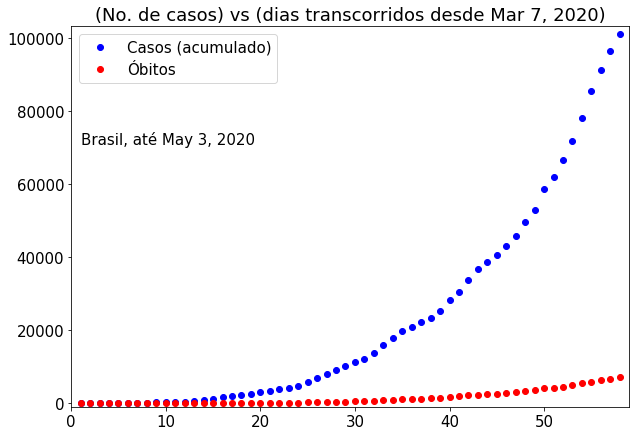

In [29]:
plot_casos('Brasil',data)

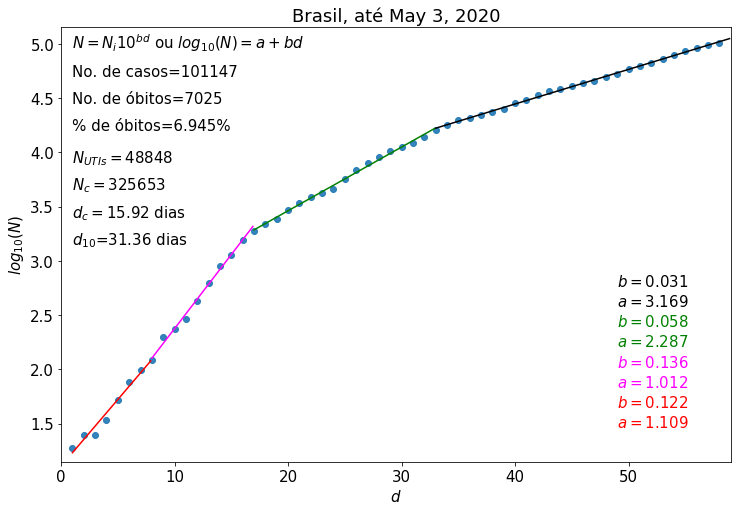

In [26]:
ifel = 7; ifec = 16; ifd = 32; Nuti = 48848; Puti = 15; lugar = 'Brasil'; data = datad[ndias]
plot_log10casos(ifel,ifec,ifd,Nuti,Puti,lugar,data)

## Rio Grande do Sul
O número de leitos de UTI disponíveis atualmente no RS [https://gauchazh.clicrbs.com.br/saude/noticia/2020/03/com-poucos-leitos-de-uti-rio-grande-do-sul-se-prepara-para-tratar-casos-graves-de-coronavirus-ck87j7jbr01iq01rz0gpv1fpx.html]: $N_{uti} = 3200$. Abaixo estão dados do número de casos de covid-19 no RS obtidos em [https://www.ufsm.br/coronavirus/rio-grande-do-sul/].

In [16]:
csvf = csv.reader(open('covid19_rs.csv')); datad = []; casosd = []; obitosd = []
for row in csvf:
    datad.append(row[0]); casosd.append(row[1]); obitosd.append(row[2])
ndias = len(datad)-1; print('No. de dias desde '+datad[1]+' = ',ndias); print(datad[0:ndias+1])
casos = np.zeros(ndias); casos = np.array(casosd[1:ndias+1]); 
casos = np.asfarray(casos,float); print('No. de casos = ', casos.astype(int))
obitos = np.zeros(ndias); obitos = np.array(obitosd[1:ndias+1]); 
obitos = np.asfarray(obitos,float); print('No. de óbitos = ',obitos.astype(int))
dia = np.zeros(ndias,dtype='int')
for j in range(0,ndias):
    dia[j] = j+1
log10casos = np.zeros(ndias)
for j in range(0,ndias):
    if casos[j] == 0:
        log10casos[j] = 0
    else:
        log10casos[j] = math.log10(casos[j])
cmax = np.amax(casos); lcmax = math.log10(cmax); cmin = np.amin(casos)
if cmin <= 1:
    lcmin = 0
else:
    lcmin = math.log10(cmin)

No. de dias desde Mar 7, 2020 =  58
['Data', 'Mar 7, 2020', 'Mar 8, 2020', 'Mar 9, 2020', 'Mar 10, 2020', 'Mar 11, 2020', 'Mar 12, 2020', 'Mar 13, 2020', 'Mar 14, 2020', 'Mar 15, 2020', 'Mar 16, 2020', 'Mar 17, 2020', 'Mar 18, 2020', 'Mar 19, 2020', 'Mar 20, 2020', 'Mar 21, 2020', 'Mar 22, 2020', 'Mar 23, 2020', 'Mar 24, 2020', 'Mar 25, 2020', 'Mar 26, 2020', 'Mar 27, 2020', 'Mar 28, 2020', 'Mar 29, 2020', 'Mar 30, 2020', 'Mar 31, 2020', 'Apr 1, 2020', 'Apr 2, 2020', 'Apr 3, 2020', 'Apr 4, 2020', 'Apr 5, 2020', 'Apr 6, 2020', 'Apr 7, 2020', 'Apr 8, 2020', 'Apr 9, 2020', 'Apr 10, 2020', 'Apr 11, 2020', 'Apr 12, 2020', 'Apr 13, 2020', 'Apr 14, 2020', 'Apr 15, 2020', 'Apr 16, 2020', 'Apr 17, 2020', 'Apr 18, 2020', 'Apr 19, 2020', 'Apr 20, 2020', 'Apr 21, 2020', 'Apr 22, 2020', 'Apr 23, 2020', 'Apr 24, 2020', 'Apr 25, 2020', 'Apr 26, 2020', 'Apr 27, 2020', 'Apr 28, 2020', 'Apr 29, 2020', 'Apr 30, 2020', 'May 1, 2020', 'May 2, 2020', 'May 3, 2020']
No. de casos =  [   0    0    0    1    2 

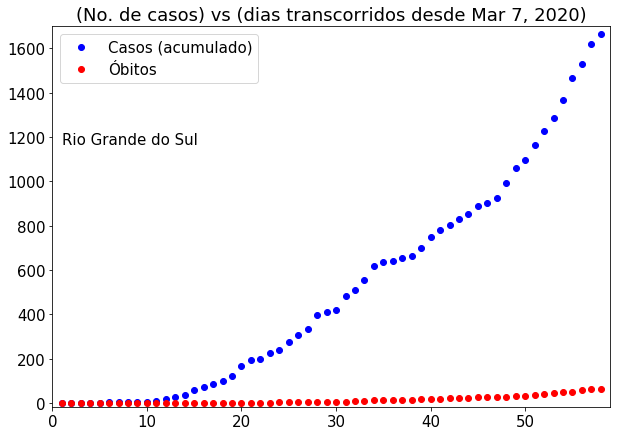

In [17]:
plot_casos('Rio Grande do Sul')

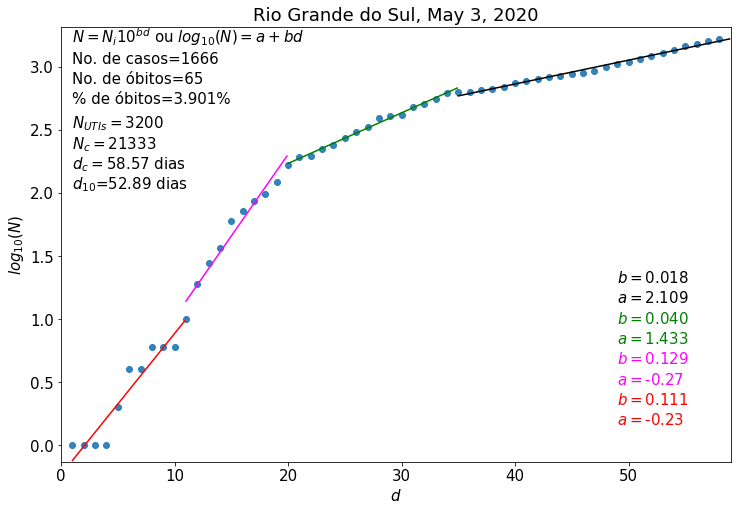

In [18]:
ifel = 10; ifec = 19; ifd = 34; Nuti = 3200; Puti = 15; lugar = 'Rio Grande do Sul'; data = datad[ndias]
plot_log10casos(ifel,ifec,ifd,Nuti,Puti,lugar,data)

## Santa Maria
Para Santa Maria usamos dados obtidos em [https://www.ufsm.br/coronavirus/observatorio/]. Em nossa cidade temos $N_{uti}=45$ [https://diariosm.com.br/not%C3%ADcias/sa%C3%BAde/santa-maria-conta-com-169-leitos-de-covid-19-e-33-pacientes-internados-1.2221939].

In [19]:
csvf = csv.reader(open('covid19_sm.csv')); datad = []; casosd = []#; obitosd = []
for row in csvf:
    datad.append(row[0]); casosd.append(row[1])#; obitosd.append(row[1])
ndiasl = len(datad)-1#; print('No. de dias na lista =',ndiasl)#; print('Datas na lista = ',datad)
for j in range(0,ndiasl):
    if len(datad[j]) < 12:
        datad[j] = datad[j][0:4]+str(0)+datad[j][4:12]
#print('Datas na lista = ',datad)
casosl = np.zeros(ndiasl); casosl = np.array(casosd[1:ndiasl+1])
casosl = np.asfarray(casosl,float)#; print('No. casos diario na lista = ',casosl.astype(int))
today = datetime.date.today(); hoje = today.strftime("%b %d, %Y")#; print('Hoje é ',hoje)
datelist = pd.date_range(start=datad[1],end=hoje); ndias = len(datelist); print('No. de dias = ',ndias)
datel = []
for j in range(0,ndias):
    datel.append(datelist[j].strftime("%b %d, %Y"))
print('Datas = ',datel)
diario = np.zeros(ndias)
k = 0
for j in range(0,ndias):
    if k < ndiasl and datel[j] == datad[k+1]:
        diario[j] = casosl[k]; k += 1
    else:
        diario[j] = 0
    #print(datel[j],diario[j])
#print(diario)
casos = np.zeros(ndias); casos[0] = diario[0]
for j in range(1,ndias):
    casos[j] = casos[j-1] + diario[j]
print('No. de casos = ',casos)
dia = np.zeros(ndias,dtype='int')
for j in range(0,ndias):
    dia[j] = j+1
log10casos = np.zeros(ndias)
for j in range(0,ndias):
    if casos[j] == 0:
        log10casos[j] = 0
    else:
        log10casos[j] = math.log10(casos[j])
obitos = np.zeros(ndias)
cmax = np.amax(casos); lcmax = math.log10(cmax); cmin = np.amin(casos)
if cmin <= 1:
    lcmin = 0
else:
    lcmin = math.log10(cmin)

No. de dias =  46
Datas =  ['Mar 20, 2020', 'Mar 21, 2020', 'Mar 22, 2020', 'Mar 23, 2020', 'Mar 24, 2020', 'Mar 25, 2020', 'Mar 26, 2020', 'Mar 27, 2020', 'Mar 28, 2020', 'Mar 29, 2020', 'Mar 30, 2020', 'Mar 31, 2020', 'Apr 01, 2020', 'Apr 02, 2020', 'Apr 03, 2020', 'Apr 04, 2020', 'Apr 05, 2020', 'Apr 06, 2020', 'Apr 07, 2020', 'Apr 08, 2020', 'Apr 09, 2020', 'Apr 10, 2020', 'Apr 11, 2020', 'Apr 12, 2020', 'Apr 13, 2020', 'Apr 14, 2020', 'Apr 15, 2020', 'Apr 16, 2020', 'Apr 17, 2020', 'Apr 18, 2020', 'Apr 19, 2020', 'Apr 20, 2020', 'Apr 21, 2020', 'Apr 22, 2020', 'Apr 23, 2020', 'Apr 24, 2020', 'Apr 25, 2020', 'Apr 26, 2020', 'Apr 27, 2020', 'Apr 28, 2020', 'Apr 29, 2020', 'Apr 30, 2020', 'May 01, 2020', 'May 02, 2020', 'May 03, 2020', 'May 04, 2020']
No. de casos =  [ 4.  5.  5.  5.  5.  5.  5.  6.  7.  7.  7.  7.  7.  7.  8.  8.  8.  8.
  9. 10. 10. 10. 10. 13. 19. 23. 23. 23. 24. 24. 26. 26. 26. 26. 27. 31.
 31. 32. 32. 33. 33. 33. 33. 33. 33. 33.]


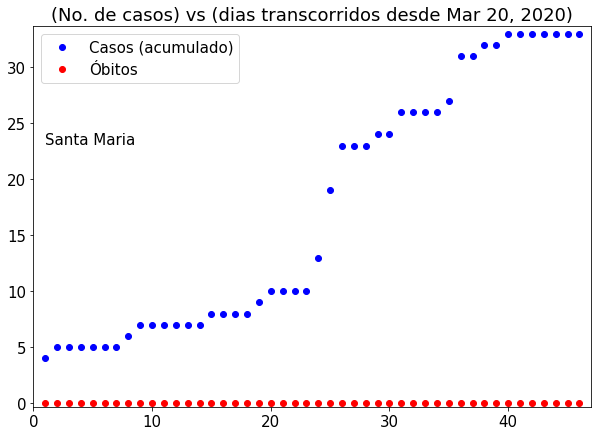

In [20]:
plot_casos('Santa Maria')

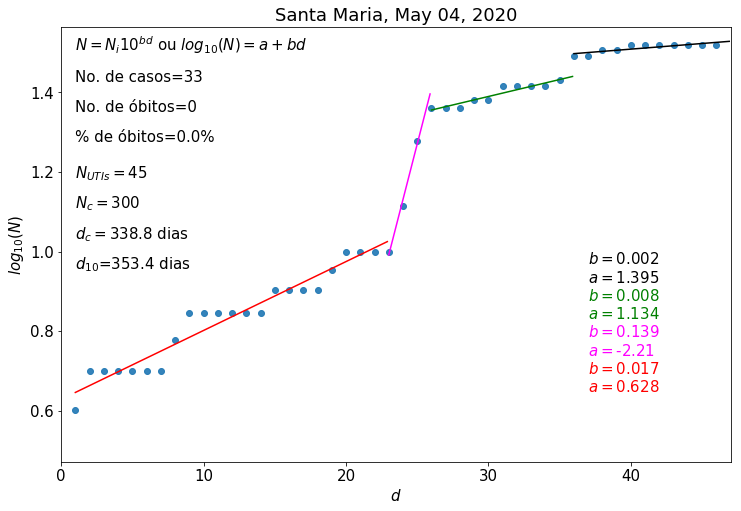

In [21]:
ifel = 22; ifec = 25; ifd = 35; Nuti = 45; Puti = 15; lugar = 'Santa Maria'; data = datel[ndias-1]
plot_log10casos(ifel,ifec,ifd,Nuti,Puti,lugar,data)